# Búsqueda de imagenes

**Instrucciones**

Iniciar Milvus

~~~bash
cd deployments/milvus
./up.sh
~~~


**Referencias**

- [towhee](https://towhee.io/)
- [Build a Milvus Powered Image Search Engine in Minutes](https://github.com/milvus-io/bootcamp/blob/master/solutions/reverse_image_search/1_build_image_search_engine.ipynb)

In [2]:
#!pip install pymilvus towhee

## Preparación de datos

- Nota: se usan [datos de ejemplo de Towhee](https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip). Cambiar a datos propios.

In [5]:
import os
if not 'reverse_image_search.csv' in os.listdir():
    !curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
    !unzip -q -o reverse_image_search.zip

In [6]:
import pandas as pd

df = pd.read_csv('reverse_image_search.csv')
df.head()

,id,path,label
0,0,./train/brain_coral/n01917289_1783.JPEG,brain_coral
1,1,./train/brain_coral/n01917289_4317.JPEG,brain_coral
2,2,./train/brain_coral/n01917289_765.JPEG,brain_coral
3,3,./train/brain_coral/n01917289_1079.JPEG,brain_coral
4,4,./train/brain_coral/n01917289_2484.JPEG,brain_coral


In [7]:
import cv2
from towhee._types.image import Image

Indexar las imagenes y agrupar por categorías.

In [8]:
id_img = df.set_index('id')['path'].to_dict()
label_ids = {}
for label in set(df['label']):
    label_ids[label] = list(df[df['label']==label].id)

In [13]:
len(id_img),len(label_ids)

(1000, 100)

In [14]:
def read_images(results):
    imgs = []
    for re in results:
        path = id_img[re.id]
        imgs.append(Image(cv2.imread(path), 'BGR'))
    return imgs

def ground_truth(path):
    label = path.split('/')[-2]
    return label_ids[label]

## Crear una colección en Milvus

In [15]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

connections.connect(host='127.0.0.1', port='19530')

In [16]:
def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    # create IVF_FLAT index for collection.
    index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":2048}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

## Cargar embeddings

In [18]:
import towhee

In [20]:
%%time
collection = create_milvus_collection('reverse_image_search', 2048)

dc = (
    towhee.read_csv('reverse_image_search.csv')      
      .runas_op['id', 'id'](func=lambda x: int(x))      
      .image_decode['path', 'img']()
      .image_embedding.timm['img', 'vec'](model_name='resnet50')
      .to_milvus['id', 'vec'](collection=collection, batch=100)
)

CPU times: user 1min 35s, sys: 4.99 s, total: 1min 40s
Wall time: 12.2 s


img,result_img
,
,
,

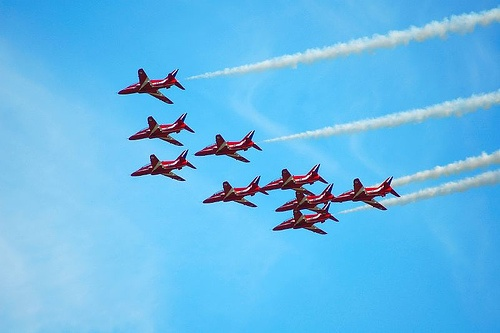
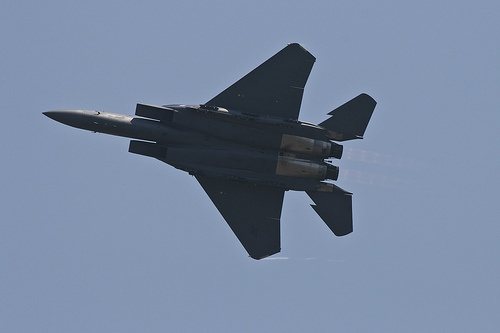
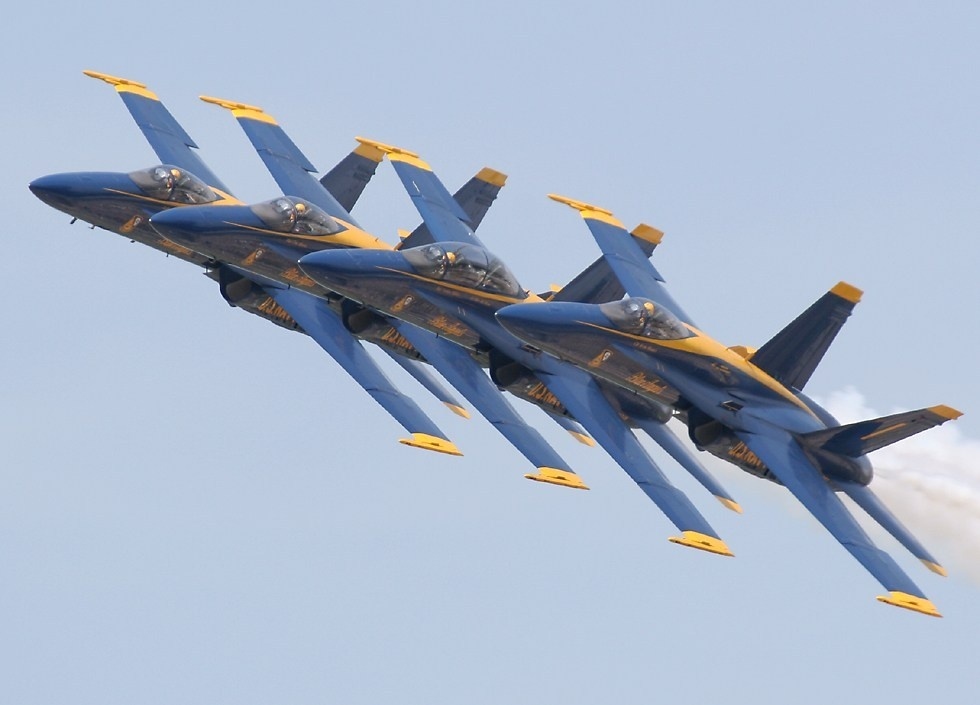
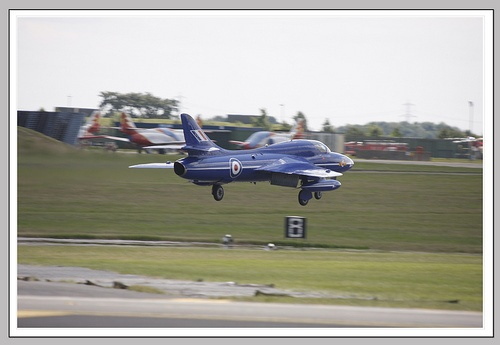
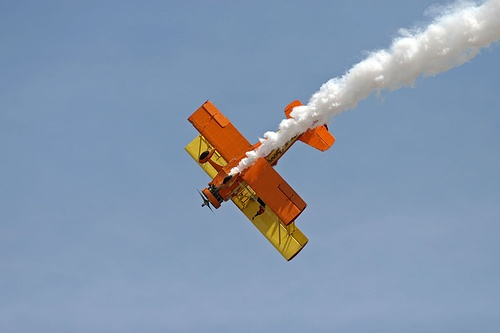
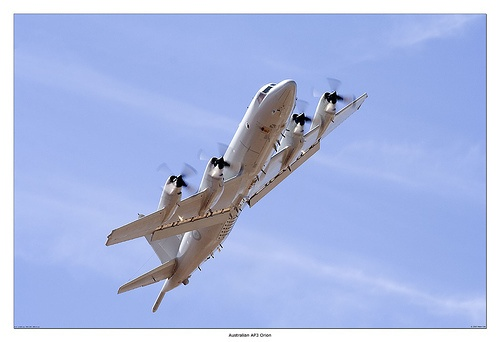
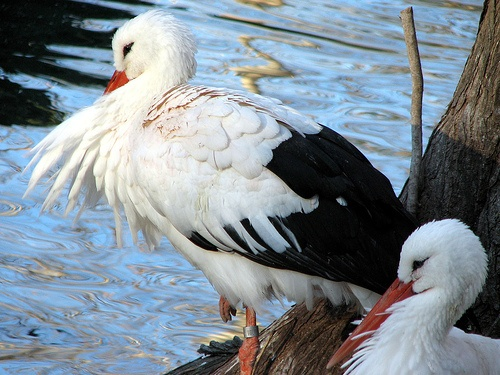
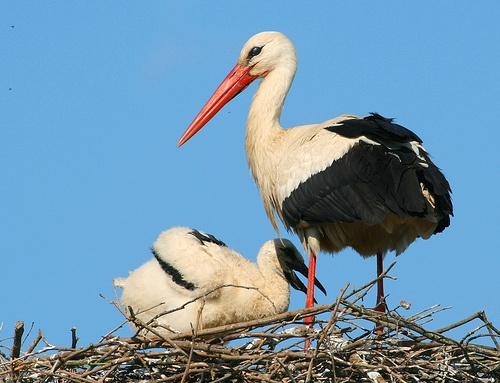
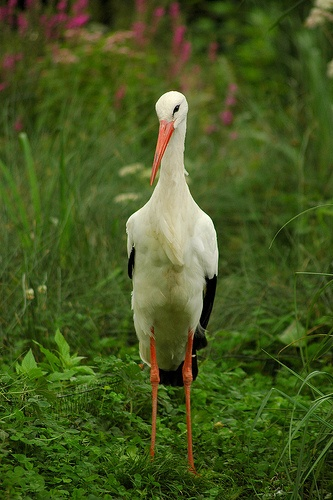
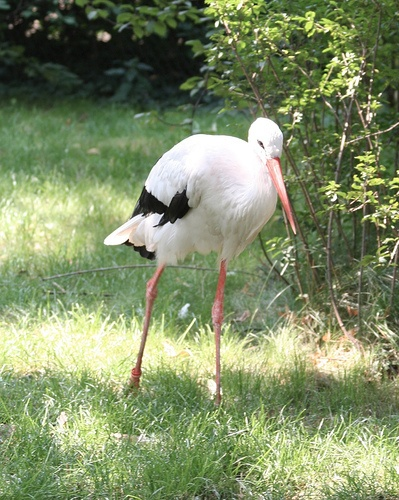
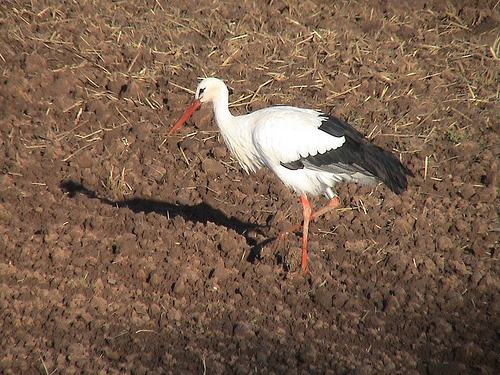
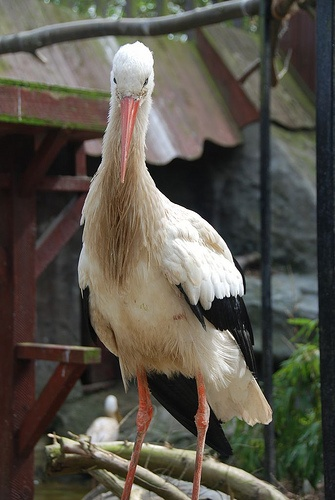
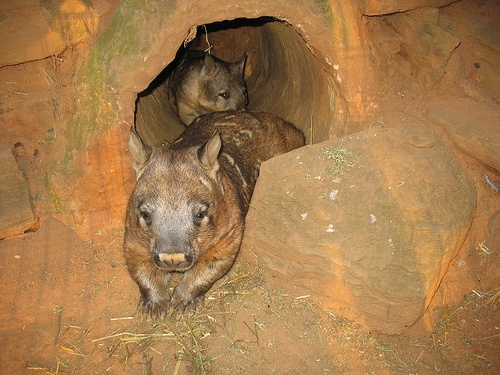
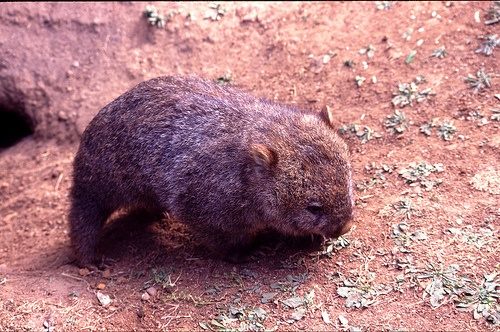
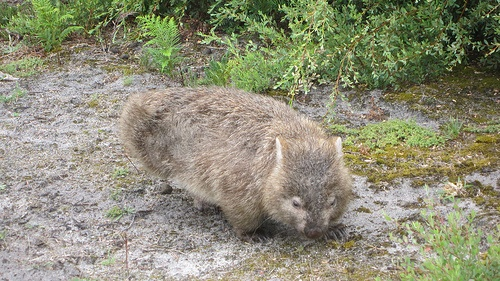
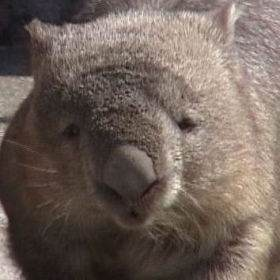
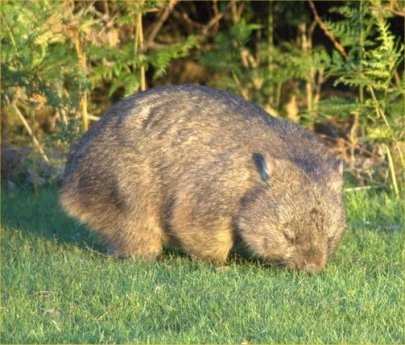
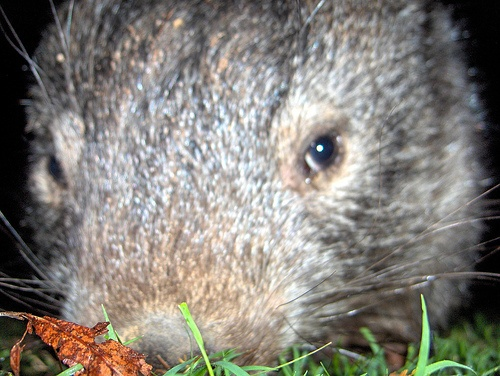

In [21]:
(
    towhee.glob['path']('./test/w*/*.JPEG')
      .image_decode['path', 'img']()
      .image_embedding.timm['img', 'vec'](model_name='resnet50')
      .milvus_search['vec', 'result'](collection=collection, limit=5)
      .runas_op['result', 'result_img'](func=read_images)
      .select['img', 'result_img']()
      .show()
)

## Evaluación

In [23]:
%%time
benchmark = (
    towhee.glob['path']('./test/*/*.JPEG')
        .image_decode['path', 'img']()
        .image_embedding.timm['img', 'vec'](model_name='resnet50')
        .milvus_search['vec', 'result'](collection=collection, limit=10)
        .runas_op['path', 'ground_truth'](func=ground_truth)
        .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
        .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
        .evaluate['ground_truth', 'result']('resnet50')
        .report()
)

,mean_hit_ratio,mean_average_precision
resnet50,0.685,0.886941


CPU times: user 9.31 s, sys: 473 ms, total: 9.78 s
Wall time: 2.01 s


In [24]:
%%time
collection = create_milvus_collection('reverse_image_search_norm', 2048)

dc = (
    towhee.read_csv('reverse_image_search.csv')
      .runas_op['id', 'id'](func=lambda x: int(x))
      .image_decode['path', 'img']()
      .image_embedding.timm['img', 'vec'](model_name='resnet50')
      .tensor_normalize['vec', 'vec']()
      .to_milvus['id', 'vec'](collection=collection, batch=100)
)

CPU times: user 1min 38s, sys: 5.36 s, total: 1min 44s
Wall time: 12.6 s


## Optimización I

In [25]:
%%time
benchmark = (
    towhee.glob['path']('./test/*/*.JPEG')
        .image_decode['path', 'img']()
        .image_embedding.timm['img', 'vec'](model_name='resnet50')
        .tensor_normalize['vec', 'vec']()
        .milvus_search['vec', 'result'](collection=collection, limit=10)
        .runas_op['path', 'ground_truth'](func=ground_truth)
        .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
        .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
        .evaluate['ground_truth', 'result']('resnet50')
        .report()
)

,mean_hit_ratio,mean_average_precision
resnet50,0.781,0.916659


CPU times: user 9.18 s, sys: 522 ms, total: 9.71 s
Wall time: 1.65 s


## Optimización II

In [26]:
import torch
import towhee
from torchvision import models
from torchvision import transforms
from PIL import Image as PILImage


torch_model = models.efficientnet_b7(pretrained=True)
torch_model = torch.nn.Sequential(*(list(torch_model.children())[:-1]))
torch_model.to('cuda' if torch.cuda.is_available() else 'cpu')
torch_model.eval()
preprocess = transforms.Compose([
    transforms.Resize(size=224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def efficientnet_b7(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = PILImage.fromarray(img.astype('uint8'), 'RGB')
    img = torch.unsqueeze(preprocess(img), 0)
    img = img.to('cuda' if torch.cuda.is_available() else 'cpu')
    embedding = torch_model(img).detach().cpu().numpy()
    return embedding.reshape([2560])

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /home/nhorro/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

In [27]:
%%time
collection = create_milvus_collection('image_search_efficientnet_b7', 2560)

dc = (
    towhee.read_csv('reverse_image_search.csv')
        .runas_op['id', 'id'](func=lambda x: int(x))
        .image_decode['path', 'img']()
        .runas_op['img', 'vec'](func=efficientnet_b7)
        .tensor_normalize['vec', 'vec']()
        .to_milvus['id', 'vec'](collection=collection, batch=100)
    )

CPU times: user 3min 46s, sys: 5.27 s, total: 3min 51s
Wall time: 28.5 s


In [29]:
%%time
benchmark = (
    towhee.glob['path']('./test/*/*.JPEG')
        .image_decode['path', 'img']()
        .runas_op['img', 'vec'](func=efficientnet_b7)
        .tensor_normalize['vec', 'vec']()
        .milvus_search['vec', 'result'](collection=collection, limit=10)
        .runas_op['path', 'ground_truth'](func=ground_truth)
        .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
        .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
        .evaluate['ground_truth', 'result']('efficientnet_b7')
        .report()
)

,mean_hit_ratio,mean_average_precision
efficientnet_b7,0.878,0.954662


CPU times: user 20.9 s, sys: 663 ms, total: 21.5 s
Wall time: 2.94 s


## Ejemplo de uso

In [31]:
from towhee.types.image_utils import from_pil

with towhee.api() as api:
    milvus_search_function = (
        api.runas_op(func=lambda img: from_pil(img))
            .image_embedding.timm(model_name='resnet50')
            .tensor_normalize()
            .milvus_search(collection='reverse_image_search_norm', limit=5)
            .runas_op(func=lambda res: [id_img[x.id] for x in res])
            .as_function()
    )
    
milvus_search_function

<towhee.functional.mixins.serve.ServeMixin.as_function.<locals>._Wrapper at 0x7ff3e16bbc70>